## Goal: Measure impact new line 3 of the Metro Santiago

In [1]:
import pandas as pd
import json

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Set default Seaborn style
sns.set()

#### Retrieve data from s3

In [2]:
!aws s3 ls dtpm-transactions/results/

2019-04-30 23:40:33          0 _SUCCESS
2019-04-30 21:57:34   38598333 part-00000-84b94a1e-55c4-47cc-8930-19bc1acb130d-c000.csv
2019-04-30 23:40:33   59108475 part-00000-f5dff8e7-a8b7-4d08-b40b-4180858e3636-c000.csv


In [3]:
!aws s3 cp --recursive s3://dtpm-transactions/results/ ../datasets/

download: s3://dtpm-transactions/results/_SUCCESS to ../datasets/_SUCCESS
download: s3://dtpm-transactions/results/part-00000-84b94a1e-55c4-47cc-8930-19bc1acb130d-c000.csv to ../datasets/part-00000-84b94a1e-55c4-47cc-8930-19bc1acb130d-c000.csv
download: s3://dtpm-transactions/results/part-00000-f5dff8e7-a8b7-4d08-b40b-4180858e3636-c000.csv to ../datasets/part-00000-f5dff8e7-a8b7-4d08-b40b-4180858e3636-c000.csv


In [4]:
!ls -l ../datasets/

total 5450576
-rw-rw-r-- 1 nicolas nicolas  121398000 abr  6 17:48 20180818.zip
-rw-rw-r-- 1 nicolas nicolas  163391608 abr 14 01:54 20181011.zip
-rw-rw-r-- 1 nicolas nicolas 1576385149 abr 25 15:37 20181103.zip
drwxrwxr-x 8 nicolas nicolas       4096 abr 30 16:56 20190101.parquet
-rw-rw-r-- 1 nicolas nicolas 1003269179 ene  1 17:58 20190101.zip
-rw-r--r-- 1 nicolas nicolas  110662416 abr  3 17:33 20190311-small.zip
-rw-rw-r-- 1 nicolas nicolas 1206821387 mar 11 18:54 20190311.zip
-rw-rw-r-- 1 nicolas nicolas 1301698260 mar 30 16:46 20190330.zip
drwxrwxr-x 3 nicolas nicolas       4096 abr 30 16:54 home
-rw-rw-r-- 1 nicolas nicolas   38598333 abr 30 21:57 part-00000-84b94a1e-55c4-47cc-8930-19bc1acb130d-c000.csv
-rw-rw-r-- 1 nicolas nicolas   59108475 abr 30 23:40 part-00000-f5dff8e7-a8b7-4d08-b40b-4180858e3636-c000.csv
-rw-rw-r-- 1 nicolas nicolas          0 abr 30 23:40 _SUCCESS
drwxrwxr-x 2 nicolas nicolas       4096 abr 15 11:55 test-folder
drwxrwxr-x 2 nicolas nicolas       4096 abr

In [3]:
path = "../datasets/part-00000-f5dff8e7-a8b7-4d08-b40b-4180858e3636-c000.csv"

In [4]:
df = pd.read_csv(path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1611899 entries, 0 to 1611898
Data columns (total 4 columns):
nombreentidad    1611899 non-null object
nombresitio      1611899 non-null object
day              1611899 non-null object
count            1611899 non-null int64
dtypes: int64(1), object(3)
memory usage: 49.2+ MB


In [6]:
df.head()

,nombreentidad,nombresitio,day,count
0,U4 - Express,CJRS-78,2019-01-08,2532
1,U2 - Su Bus,ZN-6609,2019-01-08,2142
2,U4 - Express,BCBB-89,2019-01-08,2934
3,U2 - Su Bus,WC-1134,2019-01-08,3450
4,U2 - Su Bus,ZN-6336,2019-01-08,660


#### Work only with Metro stations

In [7]:
df["nombreentidad"].value_counts()

U4 - Express          328127
U3 - Vule             311334
U2 - Su Bus           309749
U5 - Metropolitana    252816
U6 - Redbus           155969
U7 - STP              124846
U1 - Alsacia           95261
METRO - OT             31187
Tren Central            2610
Name: nombreentidad, dtype: int64

In [8]:
df = df[df["nombreentidad"] == "METRO - OT"]

#### Prepare DataFrame

In [9]:
df["day"] = df["day"] = pd.to_datetime(df["day"], format="%Y/%m/%d", errors='coerce')
df.set_index("day", inplace=True)

In [11]:
df["nombreentidad"] = df["nombreentidad"].astype("category")

#### Update station names

In [12]:
station_rules = pd.read_csv("../station_rules.csv")

In [13]:
station_rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 3 columns):
new-name    131 non-null object
old-name    131 non-null object
type        131 non-null object
dtypes: object(3)
memory usage: 3.1+ KB


In [14]:
station_rules.set_index("old-name", inplace=True)

In [15]:
station_rules.loc["Ñuble L6", "new-name"]

'Ñuble'

In [16]:
df["nombresitio"] = df["nombresitio"].apply(lambda old_name: station_rules.loc[old_name, "new-name"])

__For the impact classification by line, we need to assign each station to a line.__

### Obtaining the stations by line

Source of stations by line: __wikipedia (https://es.wikipedia.org/wiki/Metro_de_Santiago)__

In [17]:
path = "../stations.json"

In [18]:
# Load file with line and stations
stations = {}
with open(path) as jfile:  
    stations = json.load(jfile)

In [19]:
df["1"] = False
df["2"] = False
df["3"] = False
df["4"] = False
df["4A"] = False
df["5"] = False
df["6"] = False

In [20]:
def assign_line(row, stations):
    for line in stations:
        if row["nombresitio"] in stations[line]:
            row[line] = True
    return row

In [21]:
df = df.apply(lambda row: assign_line(row, stations), axis=1)

In [22]:
df.head()

,nombreentidad,nombresitio,count,1,2,3,4,4A,5,6
day,,,,,,,,,,
2018-10-24,METRO - OT,Rondizzoni,113556,False,True,False,False,False,False,False
2019-02-08,METRO - OT,Las Rejas,218406,True,False,False,False,False,False,False
2019-02-08,METRO - OT,Plaza de Puente Alto,220554,False,False,False,True,False,False,False
2019-02-26,METRO - OT,Los Leones,197802,True,False,False,False,False,False,True
2019-01-30,METRO - OT,Parque Almagro,46146,False,False,True,False,False,False,False


In [23]:
result = []

In [24]:
for line in stations:
    temp_df = df[df[line] == True][["count", "1", "2", "3", "4", "4A", "5", "6"]]
    result.append(temp_df.groupby(temp_df.index.date).sum()["count"].rename(line))

In [25]:
result = pd.concat(result, axis=1, sort=True)

In [26]:
result.tail()

,1,2,3,4,4A,5,6
2019-04-21,679050.0,388179.0,286635.0,356772.0,117449.0,459673.0,142912.0
2019-04-22,2246254.0,999158.0,831309.0,927813.0,275101.0,1239386.0,387134.0
2019-04-23,1139791.0,507328.0,423010.0,473697.0,137306.0,634792.0,199127.0
2019-04-24,1128608.0,499653.0,416072.0,468265.0,134833.0,631033.0,197518.0
2019-04-25,NaN,1.0,1.0,NaN,NaN,NaN,NaN


In [29]:
result.index = pd.to_datetime(result.index)

#### Plotting the results

In [30]:
startdate = pd.to_datetime("2018-8-1").date()
enddate = pd.to_datetime("2019-8-1").date()
result = result.loc[startdate:enddate]

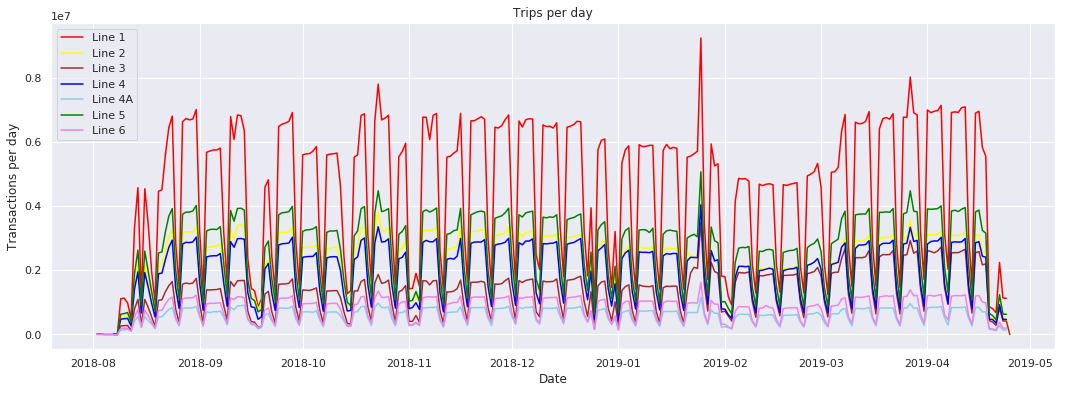

In [32]:
_ = plt.figure(figsize=(18, 6))
_ = plt.plot(result["1"], color='red', label='Line 1')
_ = plt.plot(result["2"], color='yellow', label='Line 2')
_ = plt.plot(result["3"], color='brown', label='Line 3')
_ = plt.plot(result["4"], color='blue', label='Line 4')
_ = plt.plot(result["4A"], color='skyblue', label='Line 4A')
_ = plt.plot(result["5"], color='green', label='Line 5')
_ = plt.plot(result["6"], color='violet', label='Line 6')
_ = plt.title("Trips per day")
_ = plt.xlabel('Date')
_ = plt.ylabel('Transactions per day')
_ = plt.legend(loc='upper left')

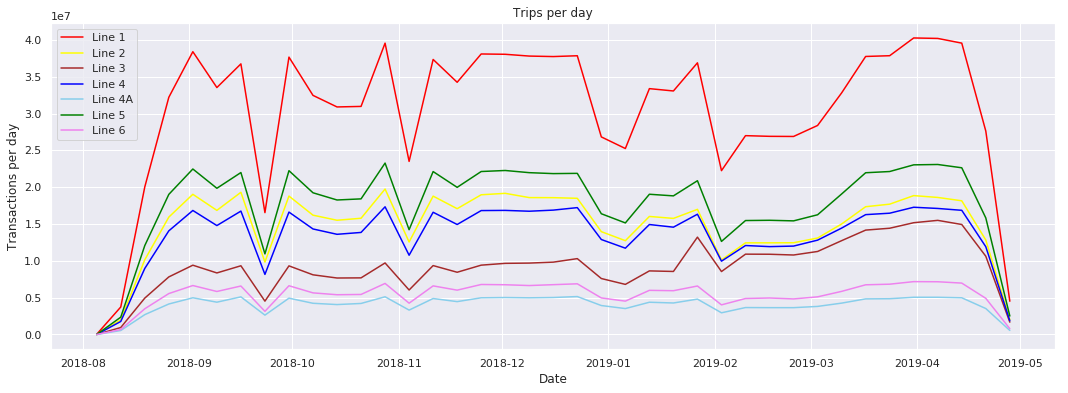

In [36]:
_ = plt.figure(figsize=(18, 6))
_ = plt.plot(result.resample("W").sum()["1"], color='red', label='Line 1')
_ = plt.plot(result.resample("W").sum()["2"], color='yellow', label='Line 2')
_ = plt.plot(result.resample("W").sum()["3"], color='brown', label='Line 3')
_ = plt.plot(result.resample("W").sum()["4"], color='blue', label='Line 4')
_ = plt.plot(result.resample("W").sum()["4A"], color='skyblue', label='Line 4A')
_ = plt.plot(result.resample("W").sum()["5"], color='green', label='Line 5')
_ = plt.plot(result.resample("W").sum()["6"], color='violet', label='Line 6')
_ = plt.title("Trips per day")
_ = plt.xlabel('Date')
_ = plt.ylabel('Transactions per day')
_ = plt.legend(loc='upper left')